# Model Evaluation

In this notebook we evaluate different machine learning models on the cleaned Ames Housing dataset.  
Steps:
1. Load cleaned data
2. Train-test split
3. Evaluate multiple models with cross-validation
4. Compare metrics (RMSE, R²)
5. Visualize results


In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load cleaned data
train = pd.read_csv("../cleaned_data/train_clean.csv")
test  = pd.read_csv("../cleaned_data/test_clean.csv")

print("Train shape:", train.shape)
print("Test shape:", test.shape)

# Features / Target
X = train.drop(["SalePrice"], axis=1)
y = np.log1p(train["SalePrice"])  # Kaggle uses log RMSE

Train shape: (1460, 231)
Test shape: (1459, 230)


In [22]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(alpha=10),
    "Lasso": Lasso(alpha=0.001),
    "RandomForest": RandomForestRegressor(n_estimators=200, random_state=42),
    "GradientBoosting": GradientBoostingRegressor(n_estimators=300, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=500, learning_rate=0.05, random_state=42),
    "LightGBM": LGBMRegressor(n_estimators=500, learning_rate=0.05, random_state=42)
}

In [23]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

results = {}
for name, model in models.items():
    neg_rmse = cross_val_score(model, X, y, scoring="neg_root_mean_squared_error", cv=kf)
    results[name] = -neg_rmse.mean()

results_df = pd.DataFrame.from_dict(results, orient="index", columns=["RMSE"]).sort_values("RMSE")
results_df

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001346 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3419
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 151
[LightGBM] [Info] Start training from score 12.030658
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001145 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3420
[LightGBM] [Info] Number of data points in the train set: 1168, number of used features: 155
[LightGBM] [Info] Start training from score 12.016898
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM]

,RMSE
GradientBoosting,0.133446
LightGBM,0.136286
XGBoost,0.141694
RandomForest,0.144126
Ridge,0.146698
Lasso,0.147544
LinearRegression,0.182070


## Model Comparison — 5-Fold CV RMSE (lower is better)
We compare several models using 5-fold cross-validation with RMSE on log(SalePrice).

In [24]:
# Recompute CV RMSE for consistency right here (uses your existing `models`, `X`, `y`)
rmse_means = {}
rmse_folds = {}  # keep per-fold for the next boxplot

for name, model in models.items():
    scores = cross_val_score(model, X, y, cv=kf, scoring="neg_root_mean_squared_error")
    rmse = -scores
    rmse_means[name] = rmse.mean()
    rmse_folds[name] = rmse

results_df = pd.DataFrame.from_dict(rmse_means, orient="index", columns=["RMSE"]).sort_values("RMSE")

display(results_df)

# Enhanced bar chart with minimalistic red palette
plt.figure(figsize=(12, 7))

# Create a subtle red palette from light to darker tones
red_palette = ['#f7d4d4', '#efb3b3', '#e79393', '#df7373', '#d75252', '#cf3232', '#b71c1c']
colors = red_palette[:len(results_df)]

# Create bars with subtle styling
bars = plt.bar(results_df.index, results_df["RMSE"], color=colors, alpha=0.85, 
               edgecolor='#8d8d8d', linewidth=0.8)

# Add clean value labels on top of bars
for bar, value in zip(bars, results_df["RMSE"]):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.0005, 
             f'{value:.4f}', ha='center', va='bottom', fontsize=11, 
             color='#333333', fontweight='normal')

# Clean, minimalistic styling
plt.title("Model Comparison: 5-Fold Cross-Validation RMSE", 
          fontsize=15, color='#333333', pad=25, fontweight='normal')
plt.ylabel("RMSE", fontsize=13, color='#333333')
plt.xlabel("Models", fontsize=13, color='#333333')

# Subtle axis styling
plt.xticks(rotation=45, ha="right", fontsize=11, color='#666666')
plt.yticks(fontsize=11, color='#666666')

# Remove top and right spines for cleaner look
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#cccccc')
ax.spines['bottom'].set_color('#cccccc')

# Subtle grid
plt.grid(axis='y', alpha=0.2, linestyle='-', color='#cccccc')

# Highlight the best model with a slightly darker red
bars[0].set_color('#b71c1c')
bars[0].set_alpha(0.9)

plt.tight_layout()
plt.show()


KeyboardInterrupt: 

## Cross-Validation Stability — Per-Fold RMSE
Showing the per-fold distribution demonstrates model stability (lower and tighter is better).

C:\Users\87114\AppData\Local\Temp\ipykernel_12040\1926537614.py:24: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(grouped, labels=results_df.index, showmeans=True,


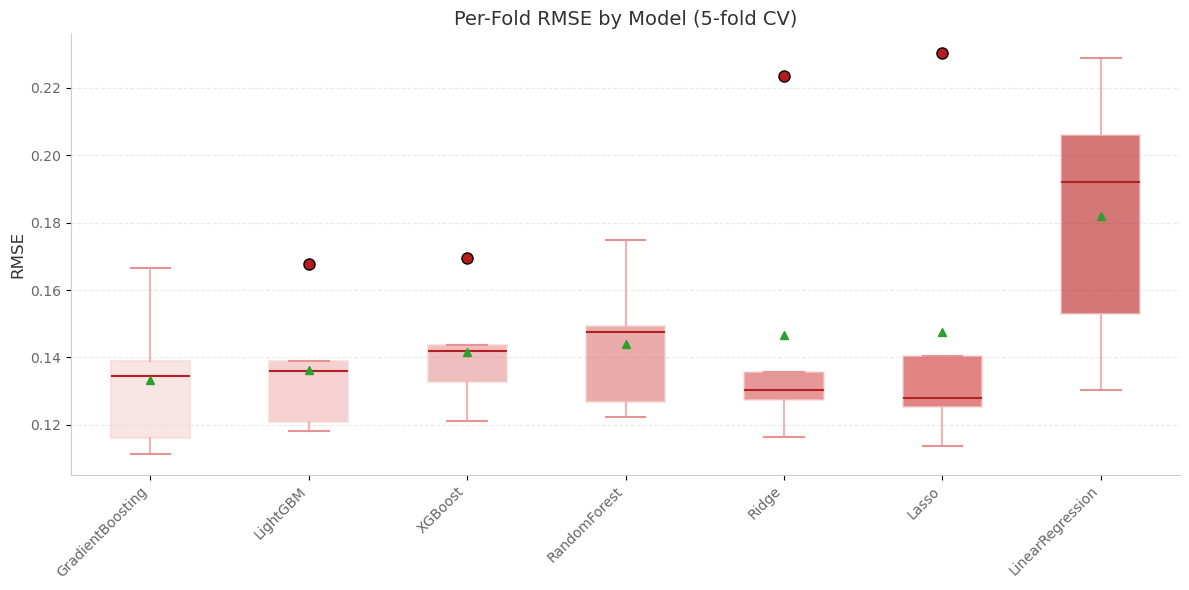

In [ ]:
# Build tidy per-fold table from rmse_folds computed above
cv_rows = []
for name, arr in rmse_folds.items():
    for i, v in enumerate(arr, 1):
        cv_rows.append({"Model": name, "Fold": i, "RMSE": v})
cv_df = pd.DataFrame(cv_rows)

# Enhanced Boxplot grouped by model (matplotlib)
plt.figure(figsize=(12, 6))  # Wider figure

# Define a subtle red palette
red_palette = ['#f7d4d4', '#efb3b3', '#e79393', '#df7373', '#d75252', '#cf3232', '#b71c1c']
num_models = len(results_df.index)
colors = red_palette[:num_models]

# Define boxplot properties with the red palette
boxprops = dict(linestyle='-', linewidth=1.5, color=colors[0])  # Use a color from the palette
medianprops = dict(linestyle='-', linewidth=1.5, color='firebrick')
whiskerprops = dict(linestyle='-', linewidth=1.5, color=colors[1])  # Use a different color
capprops = dict(linestyle='-', linewidth=1.5, color=colors[2])  # And another
flierprops = dict(marker='o', markerfacecolor=colors[-1], markersize=8, markeredgecolor='black')  # Darker red

grouped = [cv_df[cv_df["Model"] == m]["RMSE"].values for m in results_df.index]
plt.boxplot(grouped, labels=results_df.index, showmeans=True,
            boxprops=boxprops, medianprops=medianprops,
            whiskerprops=whiskerprops, capprops=capprops,
            flierprops=flierprops, patch_artist=True)  # Enable filling boxes

# Fill boxes with colors from the palette
for patch, color in zip(plt.gca().patches, colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)  # Transparency

plt.title("Per-Fold RMSE by Model (5-fold CV)", fontsize=14, color='#333333')  # Larger title
plt.ylabel("RMSE", fontsize=12, color='#333333')
plt.xticks(rotation=45, ha="right", fontsize=10, color='#666666')  # More readable x-axis labels
plt.yticks(fontsize=10, color='#666666')
plt.grid(axis='y', linestyle='--', alpha=0.4, color='#cccccc')  # Add grid for easier reading

# Remove top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#cccccc')
ax.spines['bottom'].set_color('#cccccc')

plt.tight_layout()
plt.show()

## Residuals — Distribution (Best Model)
Residuals should be centered near 0 and roughly symmetric; large tails/outliers indicate areas to improve.

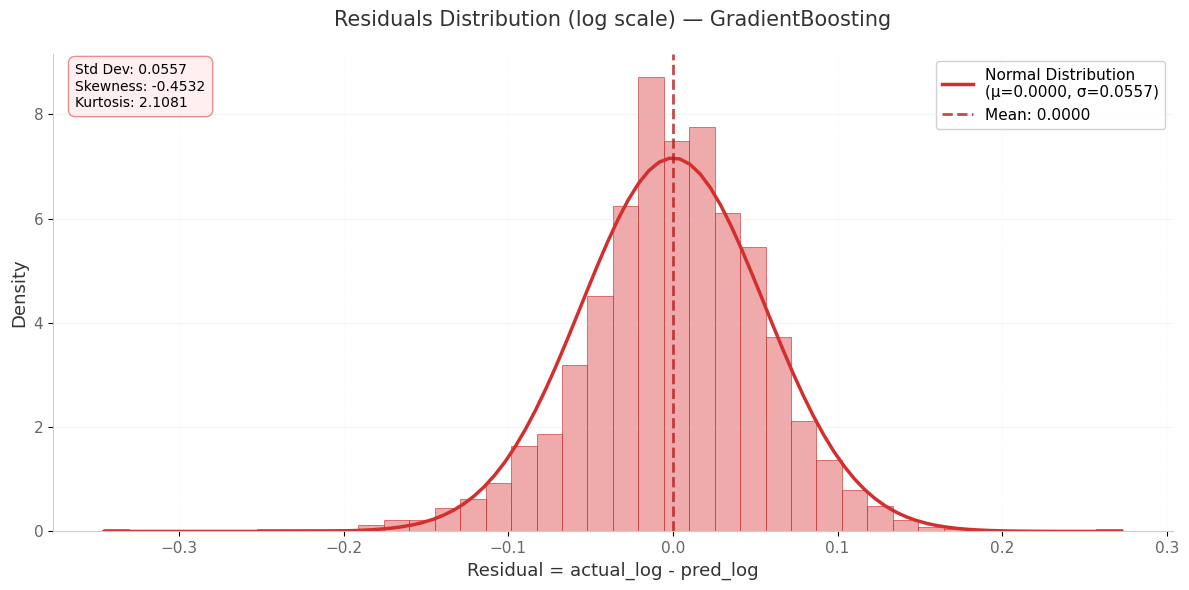

MODEL PERFORMANCE: GradientBoosting
Train RMSE (log): 0.055647
Train R²:         0.980579
Residual Mean:    0.000000
Residual Std:     0.055666


c:\Users\87114\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
# Get residuals from the best model
resid_log = y - y_pred

# Enhanced histogram with red palette and minimalistic design
plt.figure(figsize=(12, 6))

# Create histogram with subtle red styling
n, bins, patches = plt.hist(resid_log, bins=40, alpha=0.6, color='#e57373', 
                           edgecolor='#c62828', linewidth=0.7, density=True)

# Add a fitted normal distribution curve for comparison
mu, sigma = resid_log.mean(), resid_log.std()
x = np.linspace(resid_log.min(), resid_log.max(), 100)
normal_curve = (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
plt.plot(x, normal_curve, color='#d32f2f', linewidth=2.5, 
         label=f'Normal Distribution\n(μ={mu:.4f}, σ={sigma:.4f})')

# Add vertical line at mean
plt.axvline(mu, color='#b71c1c', linestyle='--', linewidth=2, alpha=0.8, 
            label=f'Mean: {mu:.4f}')

# Clean, minimalistic styling
plt.title(f'Residuals Distribution (log scale) — {best_model_name}', 
          fontsize=15, color='#333333', pad=20, fontweight='normal')
plt.xlabel('Residual = actual_log - pred_log', fontsize=13, color='#333333')
plt.ylabel('Density', fontsize=13, color='#333333')

# Subtle grid
plt.grid(axis='y', alpha=0.2, linestyle='-', color='#cccccc')
plt.grid(axis='x', alpha=0.15, linestyle=':', color='#cccccc')

# Clean legend styling
plt.legend(fontsize=11, loc='upper right', frameon=True, fancybox=True, 
           shadow=False, framealpha=0.9, edgecolor='#cccccc')

# Add statistics text box with subtle red theme
stats_text = f'Std Dev: {sigma:.4f}\nSkewness: {resid_log.skew():.4f}\nKurtosis: {resid_log.kurtosis():.4f}'
plt.text(0.02, 0.98, stats_text, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', 
         bbox=dict(boxstyle='round,pad=0.5', facecolor='#ffebee', 
                   alpha=0.8, edgecolor='#e57373', linewidth=1))

# Remove top and right spines for cleaner look
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#cccccc')
ax.spines['bottom'].set_color('#cccccc')

# Style tick labels
plt.xticks(fontsize=11, color='#666666')
plt.yticks(fontsize=11, color='#666666')

plt.tight_layout()
plt.show()

# Enhanced performance metrics display with red accents
print(f"{'='*50}")
print(f"\033[91mMODEL PERFORMANCE: {best_model_name}\033[0m")
print(f"{'='*50}")
print(f"Train RMSE (log): {mean_squared_error(y, y_pred, squared=False):.6f}")
print(f"Train R²:         {r2_score(y, y_pred):.6f}")
print(f"Residual Mean:    {mu:.6f}")
print(f"Residual Std:     {sigma:.6f}")
print(f"{'='*50}")

## Feature Importance — What drives price?
For tree/boosting models we show feature importances; for linear models we show absolute coefficients. Top 15 features are displayed.

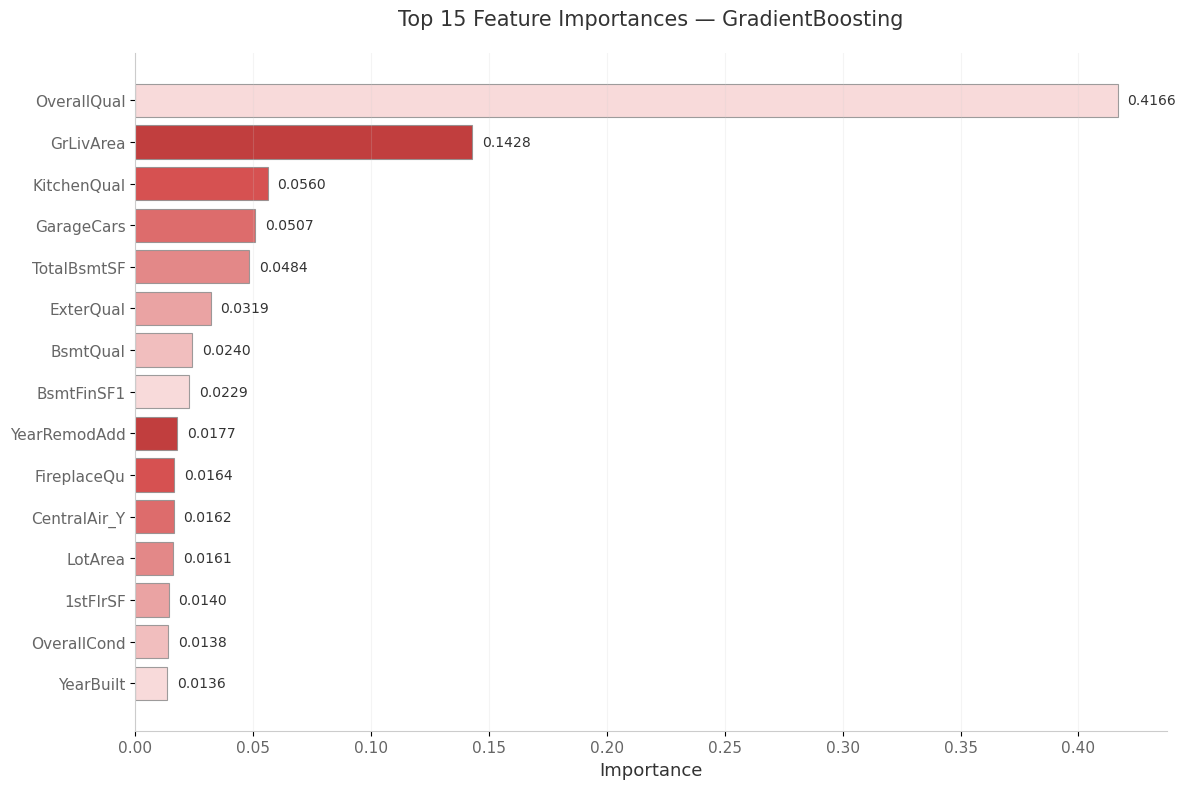

In [ ]:
top_k = 15

if hasattr(best_model, "feature_importances_"):
    importances = pd.Series(best_model.feature_importances_, index=X.columns)
    top = importances.sort_values(ascending=False).head(top_k)

    plt.figure(figsize=(12, 8))
    
    # Create a subtle red palette from light to darker tones
    red_palette = ['#f7d4d4', '#efb3b3', '#e79393', '#df7373', '#d75252', '#cf3232', '#b71c1c']
    colors = red_palette * 3  # Repeat to ensure enough colors
    colors = colors[:len(top)]  # Trim to exact length needed

    bars = plt.barh(top.index[::-1], top.values[::-1], color=colors, alpha=0.85, 
                    edgecolor='#8d8d8d', linewidth=0.8)

    # Add clean value labels at the end of bars
    for bar, value in zip(bars, top.values[::-1]):
        plt.text(bar.get_width() + max(top.values) * 0.01, bar.get_y() + bar.get_height()/2, 
                 f'{value:.4f}', ha='left', va='center', fontsize=10, 
                 color='#333333', fontweight='normal')

    # Clean, minimalistic styling
    plt.title(f"Top {top_k} Feature Importances — {best_model_name}", 
              fontsize=15, color='#333333', pad=20, fontweight='normal')
    plt.xlabel("Importance", fontsize=13, color='#333333')
    
    # Subtle axis styling
    plt.xticks(fontsize=11, color='#666666')
    plt.yticks(fontsize=11, color='#666666')
    
    # Remove top and right spines for cleaner look
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#cccccc')
    ax.spines['bottom'].set_color('#cccccc')
    
    # Subtle grid
    plt.grid(axis='x', alpha=0.2, linestyle='-', color='#cccccc')
    
    plt.tight_layout()
    plt.show()

elif hasattr(best_model, "coef_"):
    # handle linear models (coef_ can be 1D or 2D)
    coefs = np.ravel(best_model.coef_)
    coef_s = pd.Series(np.abs(coefs), index=X.columns)
    top = coef_s.sort_values(ascending=False).head(top_k)

    plt.figure(figsize=(12, 8))
    
    # Create a subtle red palette from light to darker tones
    red_palette = ['#f7d4d4', '#efb3b3', '#e79393', '#df7373', '#d75252', '#cf3232', '#b71c1c']
    colors = red_palette * 3  # Repeat to ensure enough colors
    colors = colors[:len(top)]  # Trim to exact length needed

    bars = plt.barh(top.index[::-1], top.values[::-1], color=colors, alpha=0.85, 
                    edgecolor='#8d8d8d', linewidth=0.8)

    # Add clean value labels at the end of bars
    for bar, value in zip(bars, top.values[::-1]):
        plt.text(bar.get_width() + max(top.values) * 0.01, bar.get_y() + bar.get_height()/2, 
                 f'{value:.4f}', ha='left', va='center', fontsize=10, 
                 color='#333333', fontweight='normal')

    # Clean, minimalistic styling
    plt.title(f"Top {top_k} |Absolute| Coefficients — {best_model_name}", 
              fontsize=15, color='#333333', pad=20, fontweight='normal')
    plt.xlabel("|Coefficient|", fontsize=13, color='#333333')
    
    # Subtle axis styling
    plt.xticks(fontsize=11, color='#666666')
    plt.yticks(fontsize=11, color='#666666')
    
    # Remove top and right spines for cleaner look
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#cccccc')
    ax.spines['bottom'].set_color('#cccccc')
    
    # Subtle grid
    plt.grid(axis='x', alpha=0.2, linestyle='-', color='#cccccc')
    
    plt.tight_layout()
    plt.show()
else:
    print(f"{best_model_name} does not expose importances/coefficients. Try a tree/boosting or linear model for this plot.")

## Best Model — Predicted vs Actual

After comparing cross-validation scores, we select the **best-performing model** 
(based on lowest CV RMSE) and train it on the full dataset.  
To evaluate its fit, we plot **Predicted vs Actual log(SalePrice)**:  

- Points close to the diagonal = good predictions.  
- Deviations show under- or over-estimation.  
- We also report Train RMSE and R² for reference.

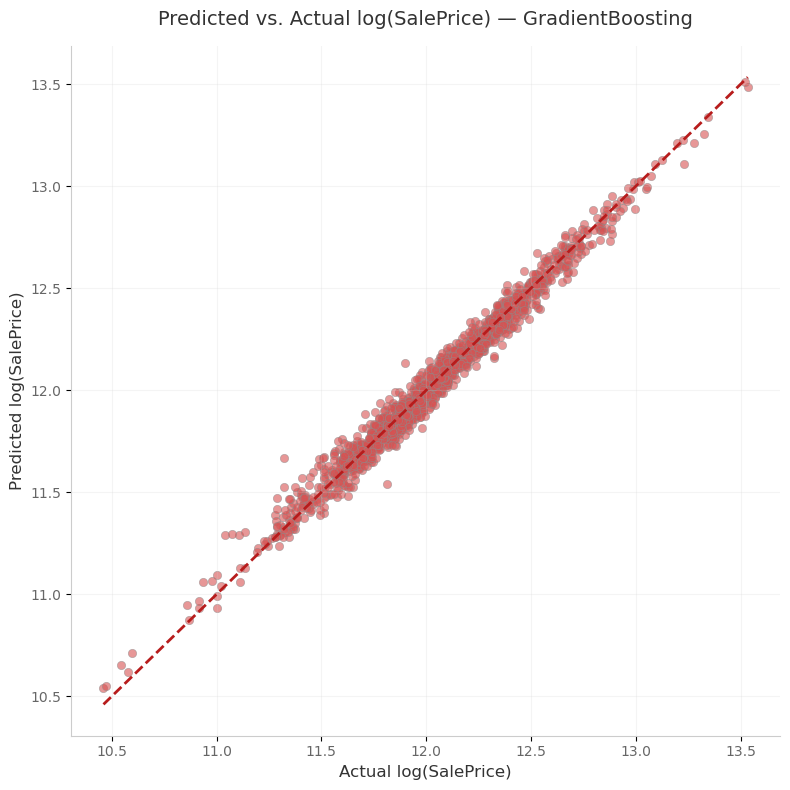

Best model: GradientBoosting
Train RMSE: 0.05564722830908099
Train R²: 0.9805794570040636


c:\Users\87114\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
best_model_name = results_df.index[0]
best_model = models[best_model_name]

best_model.fit(X, y)
y_pred = best_model.predict(X)

# Enhanced scatter plot with minimalistic red palette
plt.figure(figsize=(8, 8))  # Slightly larger for better visual impact

# Subtle red palette
red_palette = ['#f7d4d4', '#efb3b3', '#e79393', '#df7373', '#d75252', '#cf3232', '#b71c1c']

# Scatter plot with custom styling
sns.scatterplot(x=y, y=y_pred, alpha=0.6, color=red_palette[4],  # Medium red
                edgecolor='#8d8d8d', linewidth=0.5)  # Subtle edge

# Diagonal line with a darker red
plt.plot([y.min(), y.max()], [y.min(), y.max()], color=red_palette[6], linestyle='--', linewidth=2)  # Darkest red

# Clean labels and title
plt.xlabel("Actual log(SalePrice)", fontsize=12, color='#333333')
plt.ylabel("Predicted log(SalePrice)", fontsize=12, color='#333333')
plt.title(f"Predicted vs. Actual log(SalePrice) — {best_model_name}", fontsize=14, color='#333333', pad=15)

# Subtle grid
plt.grid(alpha=0.2, linestyle='-', color='#cccccc')

# Remove top and right spines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#cccccc')
ax.spines['bottom'].set_color('#cccccc')

# Style tick labels
plt.xticks(fontsize=10, color='#666666')
plt.yticks(fontsize=10, color='#666666')

plt.tight_layout()
plt.show()

print(f"Best model: {best_model_name}")
print("Train RMSE:", mean_squared_error(y, y_pred, squared=False))
print("Train R²:", r2_score(y, y_pred))